# Imports

In [2]:
%matplotlib inline
    
import numpy as np

from astropy.table import Column
from astropy.table import Table
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.cm as cm

import corner
import model_flux_ratio as mfr

In [12]:
import importlib
importlib.reload(mfr)

<module 'model_flux_ratio' from '/Users/thsyu/Software/Yp/model_flux_ratio.py'>

In [4]:
import os

print (os.getcwd())

/Users/thsyu/Software/Yp


We have our version of the MCMC that should the *best* we can do to reproduce Erik's 2013 primordial helium abundance analysis work (AOS 2013) using only optical data -- this is called 'ours_base'. It includes:

- hydrogen emissivities from Hummer & Storey 1987, using the reparameterization from AOS 2010
- helium emissivities from Porter 2012, assuming linear interpolation with RectBivariateSpline
- reddening curve from SMC

We want to then make tweaks to the above components and compare the results of those MCMCs with 'ours_base':
- 'ours_CCMred': reddening curve from Cardelli, Clayton, & Mathis 1989
- 'ours_S2018_11': hydrogen emissivities from Storey 2018, using linear interpolation with RBS
- 'ours_S2018_33': hydrogen emissivities from Storey 2018, using cubic interpolation with RBS

And maybe/eventually:
- 'ours_P2012_33': helium emissivities from Porter 2012, using cubic interpolation with RBS
- hydrogen emissivities using a PCA then RBS
- adding HeI10830

# Read in MCMC results

In [5]:
# Names of systems in AOS2015 that "qualified" for helium abundance measurements
qualifying = ['CGCG 007-025 (No.  2)', 'I Zw 18 SE 1', 'Mrk  209', 'Mrk  450 (No.  1)', 'Mrk  71 (No.  1)', \
             'SBS 0335-052E1', 'SBS 0335-052E3', 'SBS 0940+544 2', 'SBS 1030+583', 'SBS 1135+581', \
             'SBS 1152+579', 'Mrk  59', 'SBS 1415+437 (No.  2)', 'SBS 1415+437 (No.  1) 3', 'Tol 65']

qualifying.remove('SBS 1415+437 (No.  2)') # No HeI4027 for this system (they're measured to be 0)

## Store MCMC recovered parameters

In [6]:
# Different versions of the MCMC results so far
diffs = ['ours_base', 'ours_CCMred', 'ours_S2018_11', 'ours_S2018_33']

In [7]:
base_yplus = np.zeros((len(qualifying),3))
base_temp = np.zeros((len(qualifying),3))
base_dens = np.zeros((len(qualifying),3))
base_cHb = np.zeros((len(qualifying),3))
base_aH = np.zeros((len(qualifying),3))
base_aHe = np.zeros((len(qualifying),3))
base_tauHe = np.zeros((len(qualifying),3))
base_xi = np.zeros((len(qualifying),3))

In [8]:
CCMred_yplus = np.zeros((len(qualifying),3))
CCMred_temp = np.zeros((len(qualifying),3))
CCMred_dens = np.zeros((len(qualifying),3))
CCMred_cHb = np.zeros((len(qualifying),3))
CCMred_aH = np.zeros((len(qualifying),3))
CCMred_aHe = np.zeros((len(qualifying),3))
CCMred_tauHe = np.zeros((len(qualifying),3))
CCMred_xi = np.zeros((len(qualifying),3))

In [9]:
S2018_11_yplus = np.zeros((len(qualifying),3))
S2018_11_temp = np.zeros((len(qualifying),3))
S2018_11_dens = np.zeros((len(qualifying),3))
S2018_11_cHb = np.zeros((len(qualifying),3))
S2018_11_aH = np.zeros((len(qualifying),3))
S2018_11_aHe = np.zeros((len(qualifying),3))
S2018_11_tauHe = np.zeros((len(qualifying),3))
S2018_11_xi = np.zeros((len(qualifying),3))

In [10]:
S2018_33_yplus = np.zeros((len(qualifying),3))
S2018_33_temp = np.zeros((len(qualifying),3))
S2018_33_dens = np.zeros((len(qualifying),3))
S2018_33_cHb = np.zeros((len(qualifying),3))
S2018_33_aH = np.zeros((len(qualifying),3))
S2018_33_aHe = np.zeros((len(qualifying),3))
S2018_33_tauHe = np.zeros((len(qualifying),3))
S2018_33_xi = np.zeros((len(qualifying),3))

In [13]:
chisq = np.zeros((len(qualifying), 10)) # 10 is number of emission lines used in analysis
# Also equal to len(input_vals) which comes on later in this block

for d in range(len(diffs)):
    
    for npy in range(len(qualifying)):
        name = str(qualifying[npy].replace(' ', '').replace('(','').replace('-', '').replace(')','').replace('.', ''))
#        print (name)
        
        # Load .npy file
        ndim = 8
        onevar = -1

        nwalkers = 500
        nmbr = 1000
        burnin = int(0.8*nmbr) #int(0.1*nmbr)

        chains = np.load('test_data/'+diffs[d]+'/'+name+'_500walkers_1000steps.npy')
        samples = chains[:, burnin:, :].reshape((-1, ndim))

#        prenams = ['y+', 'temperature', '$log(n_{e})$', 'c(H\\beta)', '$a_{H}$', '$a_{He}$', '$\\tau_{He}', '$log(\\xi)$'] #'$n_{HI}$']

        y_plus_mcmc, temp_mcmc, log_dens_mcmc, c_Hb_mcmc, a_H_mcmc, a_He_mcmc, tau_He_mcmc, log_xi_mcmc = map(
            lambda v: (v[1], v[2] - v[1], v[1] - v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))

        # Save our MCMC parameters into an array
        if diffs[d] == 'ours_base':
            base_yplus[npy] = y_plus_mcmc
            base_temp[npy] = temp_mcmc
            base_dens[npy] = log_dens_mcmc
            base_cHb[npy] = c_Hb_mcmc
            base_aH[npy] = a_H_mcmc
            base_aHe[npy] = a_He_mcmc
            base_tauHe[npy] = tau_He_mcmc
            base_xi[npy] = log_xi_mcmc
        elif diffs[d] == 'ours_CCMred':
            CCMred_yplus[npy] = y_plus_mcmc
            CCMred_temp[npy] = temp_mcmc
            CCMred_dens[npy] = log_dens_mcmc
            CCMred_cHb[npy] = c_Hb_mcmc
            CCMred_aH[npy] = a_H_mcmc
            CCMred_aHe[npy] = a_He_mcmc
            CCMred_tauHe[npy] = tau_He_mcmc
            CCMred_xi[npy] = log_xi_mcmc
        elif diffs[d] == 'ours_S2018_11':
            S2018_11_yplus[npy] = y_plus_mcmc
            S2018_11_temp[npy] = temp_mcmc
            S2018_11_dens[npy] = log_dens_mcmc
            S2018_11_cHb[npy] = c_Hb_mcmc
            S2018_11_aH[npy] = a_H_mcmc
            S2018_11_aHe[npy] = a_He_mcmc
            S2018_11_tauHe[npy] = tau_He_mcmc
            S2018_11_xi[npy] = log_xi_mcmc
        elif diffs[d] == 'ours_S2018_33':
            S2018_33_yplus[npy] = y_plus_mcmc
            S2018_33_temp[npy] = temp_mcmc
            S2018_33_dens[npy] = log_dens_mcmc
            S2018_33_cHb[npy] = c_Hb_mcmc
            S2018_33_aH[npy] = a_H_mcmc
            S2018_33_aHe[npy] = a_He_mcmc
            S2018_33_tauHe[npy] = tau_He_mcmc
            S2018_33_xi[npy] = log_xi_mcmc
        

        # Compare input versus output emission line flux ratios and their relative errors
        input_vals = Table.read('test_data/'+name, format='ascii', delimiter=' ')

        # Generate emission line ratios based on our MCMC parameters
        mfr.generate_emission_line_ratio('test_data/'+diffs[d]+'/'+name+'_MCMCoutput', [3890.166, 4027.328, 4102.891, 4341.684, 4472.755, 4862.721, 5877.299, 6564.612, 6679.994, 7067.198], \
                input_vals['EW'], input_vals['EW'][np.where(input_vals['Wavelength']==4862.721)[0]][0], \
                y_plus_mcmc[0], temp_mcmc[0], log_dens_mcmc[0], c_Hb_mcmc[0], a_H_mcmc[0], a_He_mcmc[0], tau_He_mcmc[0], log_xi_mcmc[0])

        # Output values
        output_vals = Table.read('test_data/'+diffs[d]+'/'+name+'_MCMCoutput', format='ascii', delimiter=' ')

        # Calculate chi-squared value
        for emline in range(len(input_vals['Flux Ratio'])):
            chisq[npy][emline] = ( (output_vals['Flux Ratio'][emline] - input_vals['Flux Ratio'][emline])**2 ) \
                            / (input_vals['Flux Ratio Errors'][emline]**2)

        print (name, chisq[npy], np.sum(chisq[npy]), '\n')

CGCG007025No2 [4.73219723e-01 1.80441465e-01 2.16994306e+00 1.97001353e+00
 1.44056567e-01 0.00000000e+00 5.65519638e-01 8.72532574e-01
 1.30790913e-01 1.36586249e-03] 6.507883342346438 

IZw18SE1 [1.10993617 0.05441803 0.01713053 0.11354363 0.05549173 0.
 0.30048235 0.26086077 0.01404437 0.00398215] 1.929889722352859 

Mrk209 [1.87196085e-03 3.22399672e-04 2.20994823e-02 1.51959245e-01
 2.36016452e-03 0.00000000e+00 3.25784676e-01 4.55492147e-01
 1.05007262e-01 1.73370813e-04] 1.065070707506429 

Mrk450No1 [0.31323575 0.01909539 1.12014991 3.02493057 0.26724024 0.
 0.35300001 0.02722356 0.00524438 1.10931574] 6.239435546103749 

Mrk71No1 [0.00881874 0.06982208 0.22769464 0.4139371  0.38748289 0.
 0.52502533 0.20452389 0.61983402 0.31970414] 2.776842835758561 

SBS0335052E1 [0.00168099 0.01800542 0.13055636 0.53138245 0.14878519 0.
 0.43183019 0.1826311  0.00847041 0.13906183] 1.5924039419044558 

SBS0335052E3 [0.05800775 0.01995718 0.01798765 5.12563425 0.15270452 0.
 1.23819683 0.929

# Calculate Yp from the recovered y+ values

## Load Erik's work

In [14]:
aops2013_mcmcout = Table.read('/Users/thsyu/Software/Yp/test_data/aops2013_mcmcoutput', format='ascii', delimiter=' ')
aos2015_mcmcout = Table.read('/Users/thsyu/Software/Yp/test_data/aos2015_mcmcoutput', format='ascii', delimiter=' ')

### Plots of y+, Y

### System vs y+ (compare our 4 methods)

In [28]:
color = cm.jet(np.linspace(0,1,len(qualifying)))

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


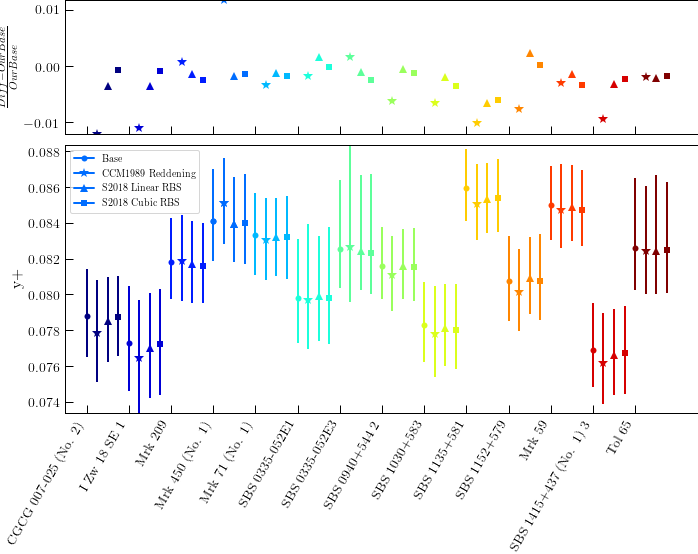

In [17]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8), sharex=True, gridspec_kw = {'height_ratios':[1.5,3]})

for obj in range(len(qualifying)):
    name = str(qualifying[obj].replace(' ', '').replace('(','').replace(')','').replace('.', ''))    
    
    ax1.plot(obj+0.25, ((CCMred_yplus[obj][0])-(base_yplus[obj][0]))/(base_yplus[obj][0]), marker='*', markersize=10, color=color[obj], label='_nolabel')
    ax1.plot(obj+0.5, ((S2018_11_yplus[obj][0])-(base_yplus[obj][0]))/(base_yplus[obj][0]), marker='^', markersize=8, color=color[obj], label='_nolabel')
    ax1.plot(obj+0.75, ((S2018_33_yplus[obj][0])-(base_yplus[obj][0]))/(base_yplus[obj][0]), marker='s', markersize=6, color=color[obj], label='_nolabel')

    if obj == 3:
        ax2.plot(obj, base_yplus[obj][0], marker='o', color=color[obj], label='Base')
        ax2.plot(obj+0.25, CCMred_yplus[obj][0], marker='*', markersize=10, color=color[obj], label='CCM1989 Reddening')
        ax2.plot(obj+0.5, S2018_11_yplus[obj][0], marker='^', markersize=8, color=color[obj], label='S2018 Linear RBS')
        ax2.plot(obj+0.75, S2018_33_yplus[obj][0],  marker='s', markersize=6, color=color[obj], label='S2018 Cubic RBS')

    ax2.errorbar(obj, base_yplus[obj][0], yerr = [[base_yplus[obj][1]], [base_yplus[obj][2]]], marker='o', color=color[obj], label='_nolabel_')
    ax2.errorbar(obj+0.25, CCMred_yplus[obj][0], yerr = [[CCMred_yplus[obj][1]], [CCMred_yplus[obj][2]]], marker='*', markersize=10, color=color[obj], label='_nolabel_')
    ax2.errorbar(obj+0.5, S2018_11_yplus[obj][0], yerr = [[S2018_11_yplus[obj][1]], [S2018_11_yplus[obj][2]]], marker='^', markersize=8, color=color[obj], label='_nolabel_')
    ax2.errorbar(obj+0.75, S2018_33_yplus[obj][0], yerr = [[S2018_33_yplus[obj][1]], [S2018_33_yplus[obj][2]]], marker='s', markersize=6, color=color[obj], label='_nolabel_')

ax1.set_ylabel(r'$\frac{Diff-Our Base}{Our Base}$')

ax2.set_xlim(-0.5, 14.5)
ax2.set_ylabel('y+')
ax2.set_xticks(np.arange(0, len(qualifying)))
ax2.set_xticklabels(qualifying, rotation=60, ha='right')
ax2.legend()

#f.savefig('/Users/thsyu/Software/Yp/test_data/system_vs_y+.pdf', overwrite=True)
f.show()

Y = Y_primordial + dY/d(O/H) * (O/H)

Y = 4y(1-Z)/1+4y

y = (y_plus + y_plusplus) * ICF(He+ + He2+) (ICF is for He)

y_plusplus = ????

Z = ????; AOS2010 takes Z=20(O/H), stated in footnote 6

### System vs y+ (AOS2015 and 4 of our methods)

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


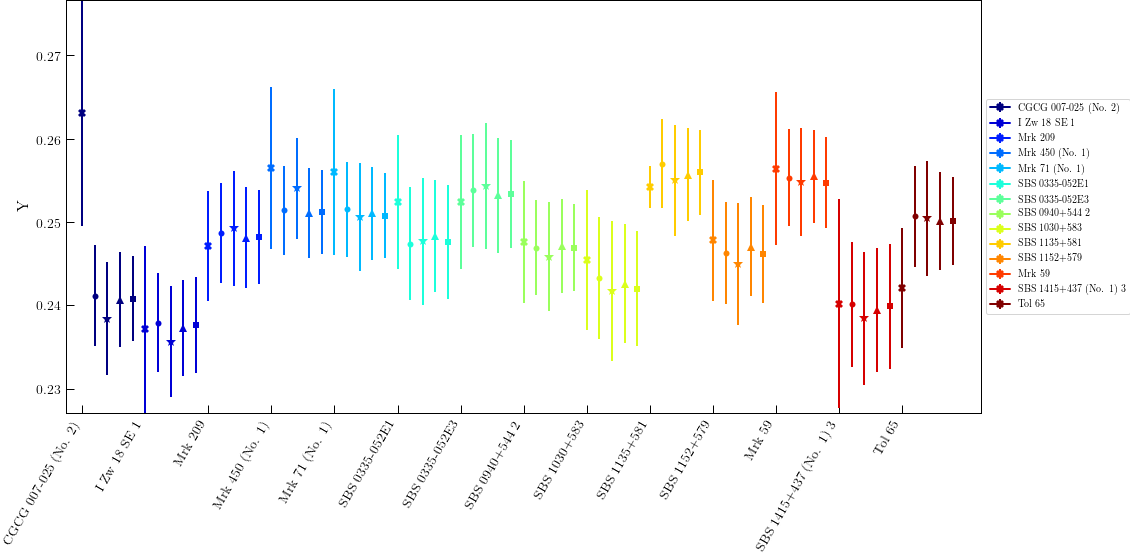

In [25]:
num = 1000
OH = np.zeros((len(qualifying), num))
base_y = np.zeros((len(qualifying), num))
base_Y = np.zeros((len(qualifying), num))
CCMred_y = np.zeros((len(qualifying), num))
CCMred_Y = np.zeros((len(qualifying), num))
S2018_11_y = np.zeros((len(qualifying), num))
S2018_11_Y = np.zeros((len(qualifying), num))
S2018_33_y = np.zeros((len(qualifying), num))
S2018_33_Y = np.zeros((len(qualifying), num))

plt.subplots(figsize=(16,8))

for obj in range(len(qualifying)):
    name = str(qualifying[obj].replace(' ', '').replace('(','').replace(')','').replace('.', ''))
    aosidx = np.where(aos2015_mcmcout['Object'] == name)[0]

#    aopsidx = np.where(aops2013_mcmcout['Object'] == name)[0]   
#     if aopsidx.size != 0:
#         For comparing to the AOPS 2013 sample:
#        base_y = base_yplus[obj][0] + aops2013_mcmcout['y++'][aopsidx]
#        base_Y = ( 4*base_y * (1 - 20*aops2013_mcmcout['OH'][aopsidx]*1e-5) ) / (1 + 4*base_y)
#        CCMred_y = CCMred_yplus[obj][0] + aops2013_mcmcout['y++'][aopsidx]
#        CCMred_Y = ( 4*CCMred_y * (1 - 20*aops2013_mcmcout['OH'][aopsidx]*1e-5) ) / (1 + 4*CCMred_y)
#        S2018_11_y = S2018_11_yplus[obj][0] + aops2013_mcmcout['y++'][aopsidx]
#        S2018_11_Y = ( 4*S2018_11_y * (1 - 20*aops2013_mcmcout['OH'][aopsidx]*1e-5) ) / (1 + 4*S2018_11_y)
#        S2018_33_y = S2018_33_yplus[obj][0] + aops2013_mcmcout['y++'][aopsidx]
#        S2018_33_Y = ( 4*S2018_33_y * (1 - 20*aops2013_mcmcout['OH'][aopsidx]*1e-5) ) / (1 + 4*S2018_33_y)    

    OH[obj] = np.random.normal(aos2015_mcmcout['OH'][aosidx], aos2015_mcmcout['OH_err'][aosidx], num)
    base_y[obj] = np.random.normal(base_yplus[obj][0], np.mean(base_yplus[0][1:]), num) + \
             np.random.normal(aos2015_mcmcout['y++'][aosidx], aos2015_mcmcout['y++_err'][aosidx], num)
    base_Y[obj] = ( 4*base_y[obj]*(1 - 20*1e-5*OH[obj] )) / (1 + 4*base_y[obj])
    CCMred_y[obj] = np.random.normal(CCMred_yplus[obj][0], np.mean(CCMred_yplus[0][1:]), num) + \
             np.random.normal(aos2015_mcmcout['y++'][aosidx], aos2015_mcmcout['y++_err'][aosidx], num)
    CCMred_Y[obj] = ( 4*CCMred_y[obj]*(1 - 20*1e-5*OH[obj] )) / (1 + 4*CCMred_y[obj])
    S2018_11_y[obj] = np.random.normal(S2018_11_yplus[obj][0], np.mean(S2018_11_yplus[0][1:]), num) + \
             np.random.normal(aos2015_mcmcout['y++'][aosidx], aos2015_mcmcout['y++_err'][aosidx], num)
    S2018_11_Y[obj] = ( 4*S2018_11_y[obj]*(1 - 20*1e-5*OH[obj] )) / (1 + 4*S2018_11_y[obj])
    S2018_33_y[obj] = np.random.normal(S2018_33_yplus[obj][0], np.mean(S2018_33_yplus[0][1:]), num) + \
             np.random.normal(aos2015_mcmcout['y++'][aosidx], aos2015_mcmcout['y++_err'][aosidx], num)
    S2018_33_Y[obj] = ( 4*S2018_33_y[obj]*(1 - 20*1e-5*OH[obj] )) / (1 + 4*S2018_33_y[obj])
        
    plt.errorbar(obj, aos2015_mcmcout['Y'][aosidx], yerr=aos2015_mcmcout['Y_err'][aosidx], marker='X', markersize=8, color=color[obj], label=qualifying[obj])
    plt.errorbar(obj+0.2, np.mean(base_Y[obj]), yerr=np.std(base_Y[obj]), marker='o', color=color[obj], linestyle='None', label='_nolabel_')
    plt.errorbar(obj+0.4, np.mean(CCMred_Y[obj]), yerr=np.std(CCMred_Y[obj]), marker='*', markersize=10, color=color[obj], linestyle='None', label='_nolabel_')
    plt.errorbar(obj+0.6, np.mean(S2018_11_Y[obj]), yerr=np.std(S2018_11_Y[obj]), marker='^', markersize=8, color=color[obj], linestyle='None', label='_nolabel_')
    plt.errorbar(obj+0.8, np.mean(S2018_33_Y[obj]), yerr=np.std(S2018_33_Y[obj]), marker='s', markersize=6, color=color[obj], linestyle='None', label='_nolabel_')

plt.xlim(-0.25, len(qualifying)+0.25)
plt.xticks(np.arange(0, len(qualifying)), qualifying, rotation=60, ha='right')
plt.ylabel(r'Y')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.savefig('/Users/thsyu/Dropbox/BCDs/primordial_helium/system_vs_diff_Y.pdf', overwrite=True)
plt.show()

### Y vs Model for Individual system

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


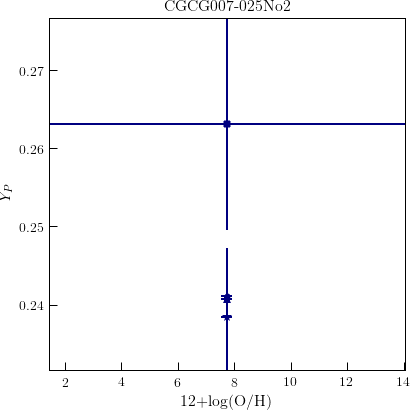

In [47]:
for obj in range(0,1):#len(qualifying)):
    name = str(qualifying[obj].replace(' ', '').replace('(','').replace(')','').replace('.', ''))
    aosidx = np.where(aos2015_mcmcout['Object'] == name)[0]
    
    plt.subplots(figsize=(6,6))
    plt.errorbar(12+np.log10(aos2015_mcmcout[aosidx]['OH']*1e-5), aos2015_mcmcout[aosidx]['Y'], xerr=12+np.log10(aos2015_mcmcout[aosidx]['OH_err']*1e-5), yerr=aos2015_mcmcout[aosidx]['Y_err'], marker='X', markersize=8, color=color[obj])
    plt.errorbar(12+np.log10(np.mean(OH[obj]*1e-5)), np.mean(base_Y[obj]), xerr=np.std(OH[obj]), yerr=np.std(base_Y[obj]), marker='o', color=color[obj])
    plt.errorbar(12+np.log10(np.mean(OH[obj]*1e-5)), np.mean(CCMred_Y[obj]), xerr=np.std(OH[obj]), yerr=np.std(CCMred_Y[obj]), marker='*', markersize=10, color=color[obj])
    plt.errorbar(12+np.log10(np.mean(OH[obj]*1e-5)), np.mean(S2018_11_Y[obj]), xerr=np.std(OH[obj]), yerr=np.std(S2018_11_Y[obj]), marker='^', markersize=8, color=color[obj])
    plt.errorbar(12+np.log10(np.mean(OH[obj]*1e-5)), np.mean(S2018_33_Y[obj]), xerr=np.std(OH[obj]), yerr=np.std(S2018_33_Y[obj]), marker='s', markersize=6, color=color[obj])
    
    plt.title(name)
    plt.xlabel(r'12+log(O/H)')
    plt.ylabel(r'$Y_{P}$')
    plt.show()

### O/H vs Y for AOS2015 and our 4 methods

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


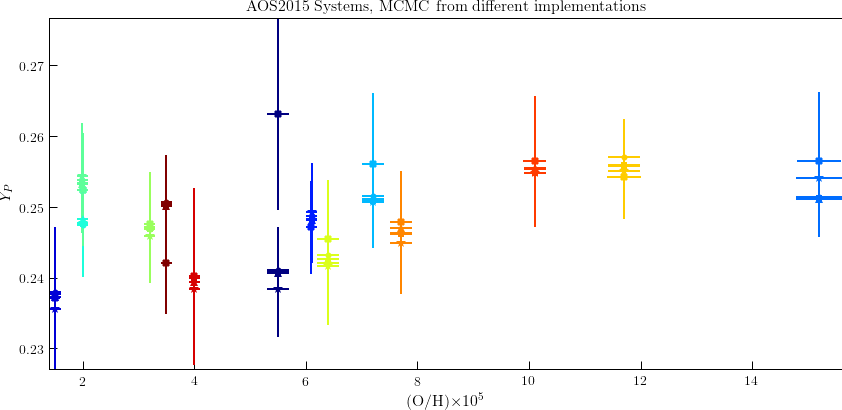

In [59]:
plt.subplots(figsize=(12,6))

for obj in range(len(qualifying)):
    name = str(qualifying[obj].replace(' ', '').replace('(','').replace(')','').replace('.', ''))
    aosidx = np.where(aos2015_mcmcout['Object'] == name)[0]
    
    plt.errorbar(aos2015_mcmcout[aosidx]['OH'], aos2015_mcmcout[aosidx]['Y'], xerr=aos2015_mcmcout[aosidx]['OH_err'], yerr=aos2015_mcmcout[aosidx]['Y_err'], marker='X', markersize=8, color=color[obj])
    plt.errorbar(np.mean(OH[obj]), np.mean(base_Y[obj]), xerr=np.std(OH[obj]), yerr=np.std(base_Y[obj]), marker='o', color=color[obj])
    plt.errorbar(np.mean(OH[obj]), np.mean(CCMred_Y[obj]), xerr=np.std(OH[obj]), yerr=np.std(CCMred_Y[obj]), marker='*', markersize=10, color=color[obj])
    plt.errorbar(np.mean(OH[obj]), np.mean(S2018_11_Y[obj]), xerr=np.std(OH[obj]), yerr=np.std(S2018_11_Y[obj]), marker='^', markersize=8, color=color[obj])
    plt.errorbar(np.mean(OH[obj]), np.mean(S2018_33_Y[obj]), xerr=np.std(OH[obj]), yerr=np.std(S2018_33_Y[obj]), marker='s', markersize=6, color=color[obj])

plt.title('AOS2015 Systems, MCMC from different implementations')
plt.xlabel(r'(O/H)$\times10^{5}$')
plt.ylabel(r'$Y_{P}$')
plt.show()

## Linear Regression to Yp

In [159]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [160]:
# Range of OH (x 10^5) values
OH_vals = np.arange(0, 16.5, 0.5 )

### On AOS2015's O/H, Y values

In [161]:
regr = linear_model.LinearRegression()
regr.fit(aos2015_mcmcout['OH'].reshape(-1, 1), aos2015_mcmcout['Y'].reshape(-1, 1))
Y_predict = regr.predict(OH_vals.reshape(-1, 1))

print ('Slope, dY/dOH', regr.coef_[0][0]*1e5)
print ('Intercept, Yp', regr.intercept_[0])

Slope, dY/dOH 64.76638276905743
Intercept, Yp 0.24699390610262548


/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


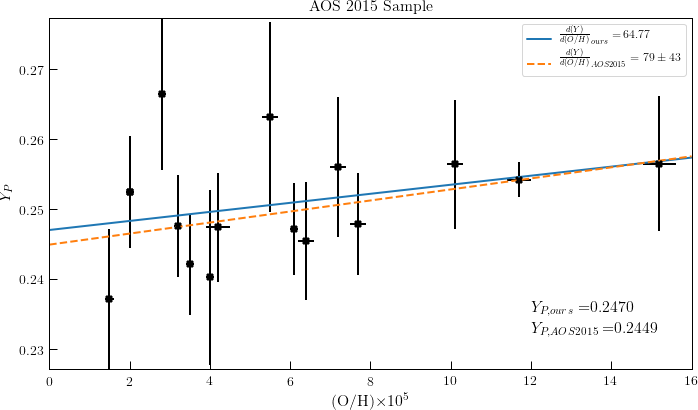

In [162]:
plt.subplots(figsize=(10, 6))
plt.errorbar(aos2015_mcmcout['OH'], aos2015_mcmcout['Y'], xerr=aos2015_mcmcout['OH_err'], yerr=aos2015_mcmcout['Y_err'], marker='X', markersize=8, linestyle='None', color='black', label='_nolabel_')
plt.plot(OH_vals, Y_predict, label=r'$\frac{d(Y)}{d(O/H)}_{ours} =\,$'+str("{:.2f}".format(regr.coef_[0][0]*1e5)))
plt.plot(OH_vals, 0.2449 + 1e-5*79*OH_vals, ls='--', label=r'$\frac{d(Y)}{d(O/H)}_{AOS2015} = 79\pm43$')
plt.text(12, 0.235, r'$Y_{P, ours} = $'+str('{:.4f}'.format(regr.intercept_[0])), fontsize=16)
plt.text(12, 0.232, r'$Y_{P, AOS2015} = $'+str(0.2449), fontsize=16)

plt.title('AOS 2015 Sample')
plt.xlabel(r'(O/H)$\times10^{5}$')
plt.ylabel(r'$Y_{P}$')
plt.legend(fontsize=12)
#plt.savefig('/Users/thsyu/Dropbox/BCDs/primordial_helium/aos2015_regression.pdf', overwrite=True)
plt.show()

### On our base O/H, Y values

In [174]:
aosidx = np.zeros(len(qualifying), dtype=int)

for obj in range(len(qualifying)):
    name = str(qualifying[obj].replace(' ', '').replace('(','').replace(')','').replace('.', ''))
    aosidx[obj] = np.where(aos2015_mcmcout['Object'] == name)[0]
    
base_regr = linear_model.LinearRegression()
base_regr.fit(aos2015_mcmcout['OH'][aosidx].reshape(-1, 1), np.mean(base_Y, axis=1).reshape(-1, 1))
base_Y_predict = base_regr.predict(OH_vals.reshape(-1, 1))

print ('Slope, dY/dOH', base_regr.coef_[0][0]*1e5)
print ('Intercept, Yp', base_regr.intercept_[0])


Slope, dY/dOH 72.87459727335798
Intercept, Yp 0.2434706991884907


In [175]:
aosidx = np.zeros(len(qualifying), dtype=int)

for obj in range(len(qualifying)):
    name = str(qualifying[obj].replace(' ', '').replace('(','').replace(')','').replace('.', ''))
    aosidx[obj] = np.where(aos2015_mcmcout['Object'] == name)[0]
    
CCMred_regr = linear_model.LinearRegression()
CCMred_regr.fit(aos2015_mcmcout['OH'][aosidx].reshape(-1, 1), np.mean(CCMred_Y, axis=1).reshape(-1, 1))
CCMred_Y_predict = CCMred_regr.predict(OH_vals.reshape(-1, 1))

print ('Slope, dY/dOH', CCMred_regr.coef_[0][0]*1e5)
print ('Intercept, Yp', CCMred_regr.intercept_[0])



Slope, dY/dOH 84.58500483786901
Intercept, Yp 0.24202011363267184


/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


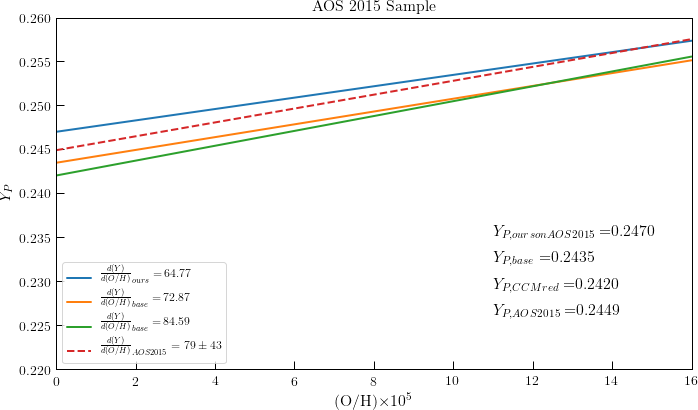

In [180]:
plt.subplots(figsize=(10, 6))
plt.plot(OH_vals, Y_predict, label=r'$\frac{d(Y)}{d(O/H)}_{ours} =\,$'+str("{:.2f}".format(regr.coef_[0][0]*1e5)))
plt.plot(OH_vals, base_Y_predict, label=r'$\frac{d(Y)}{d(O/H)}_{base} =\,$'+str("{:.2f}".format(base_regr.coef_[0][0]*1e5)))
plt.plot(OH_vals, CCMred_Y_predict, label=r'$\frac{d(Y)}{d(O/H)}_{base} =\,$'+str("{:.2f}".format(CCMred_regr.coef_[0][0]*1e5)))

plt.plot(OH_vals, 0.2449 + 1e-5*79*OH_vals, ls='--', label=r'$\frac{d(Y)}{d(O/H)}_{AOS2015} = 79\pm43$')
plt.text(11, 0.235, r'$Y_{P, ours on AOS2015} = $'+str('{:.4f}'.format(regr.intercept_[0])), fontsize=16)
plt.text(11, 0.232, r'$Y_{P, base} = $'+str('{:.4f}'.format(base_regr.intercept_[0])), fontsize=16)
plt.text(11, 0.229, r'$Y_{P, CCMred} = $'+str('{:.4f}'.format(CCMred_regr.intercept_[0])), fontsize=16)
plt.text(11, 0.226, r'$Y_{P, AOS2015} = $'+str(0.2449), fontsize=16)

plt.ylim(0.22, 0.26)
plt.title('AOS 2015 Sample')
plt.xlabel(r'(O/H)$\times10^{5}$')
plt.ylabel(r'$Y_{P}$')
plt.legend(fontsize=12)
#plt.savefig('/Users/thsyu/Dropbox/BCDs/primordial_helium/aos2015_regression.pdf', overwrite=True)
plt.show()